Still use ensamble, testing while training and ensemble all at the end

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [5]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with both sequence and structure tracks
    
    Args:
        seq_length: length of the input sequence
        struct_features: number of structural features
        struct_window: number of positions to use around middle (0 = only middle position)
    """
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)  # center + window on each side
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    
    # Structure track
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        # Use only middle position
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        # Use window around middle position
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(32, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Combine tracks
    combined = tf.keras.layers.Concatenate()([x_seq, x_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)

In [ ]:
def print_metrics_with_cm(y_true, y_pred, phase=""):
    """Helper function to print metrics and confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{phase} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")
    print(f"Sensitivity: {cm[1][1]/(cm[1][1]+cm[1][0]):.4f}")
    print(f"Specificity: {cm[0][0]/(cm[0][0]+cm[0][1]):.4f}")
    print("Confusion Matrix:")
    print(f"TN: {cm[0][0]}, FP: {cm[0][1]}")
    print(f"FN: {cm[1][0]}, TP: {cm[1][1]}")
    print("\nConfusion Matrix Format:")
    print(cm)
    
    return cm

def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/processed_data_test_after.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Shuffle data
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\n{'='*50}")
        print(f"Fold {fold}/5")
        print('='*50)
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics and print confusion matrix
        cm = print_metrics_with_cm(y_train[val_idx], y_pred_binary, f"Fold {fold} Validation")
        
        # Store metrics
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Store test predictions for later
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
    
    print("\n" + "="*50)
    print("Cross-validation Complete")
    print("="*50)
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate and print final test metrics with confusion matrix
    print("\n" + "="*50)
    print("Final Test Set Evaluation")
    print("="*50)
    cm_test = print_metrics_with_cm(y_test, test_pred_binary, "Test Set")
    
    return model

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-03 02:12:45.956763: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-03 02:12:45.956783: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 02:12:45.956790: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 02:12:45.956808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 02:12:45.956818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-03 02:12:46.680672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5150 - loss: 0.7057 - val_accuracy: 0.5469 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5536 - loss: 0.6819 - val_accuracy: 0.6514 - val_loss: 0.6422 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6550 - loss: 0.6359 - val_accuracy: 0.6718 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6812 - loss: 0.6082 - val_accuracy: 0.6836 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6974 - loss: 0.5894 - val_accuracy: 0.7175 - val_loss: 0.5707 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7207 - loss: 0.5573 - val_accuracy: 0.7362 - val_loss: 0.5432 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7430 - loss: 0.5246 - val_

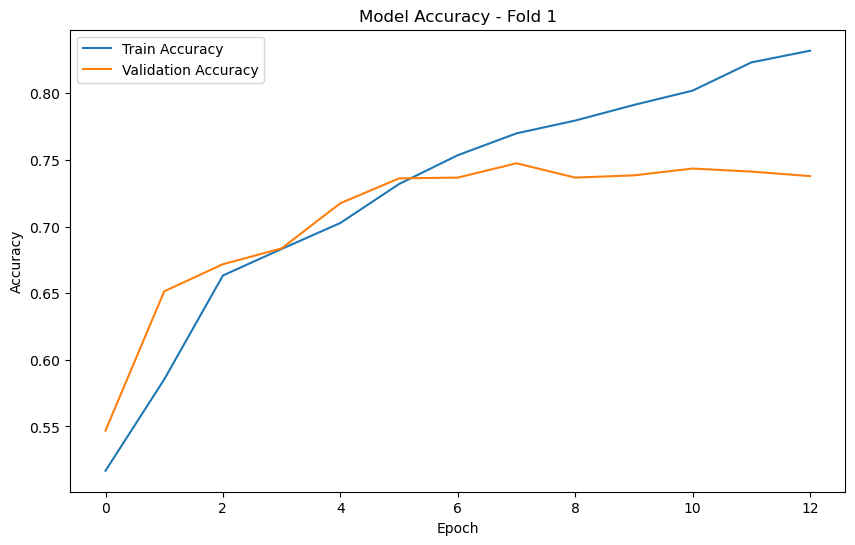

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Validation Results:
Accuracy: 0.7475
Balanced Accuracy: 0.7444
MCC: 0.4998
Sensitivity: 0.8423
Specificity: 0.6464
Confusion Matrix:
TN: 554, FP: 303
FN: 144, TP: 769

Confusion Matrix Format:
[[554 303]
 [144 769]]
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5121 - loss: 0.6993 - val_accuracy: 0.5667 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5702 - loss: 0.6801 - val_accuracy: 0.6644 - val_loss: 0.6171 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6715 - loss: 0.6112 - val_accuracy: 0.7169 - val_loss: 0.5609 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7253 - loss: 0.5584 - val_accuracy: 0.7458 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7413 - loss: 0.5374 - val_accuracy: 0.7492 - val_loss: 0.5144 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7489 - loss: 0.5198 - val_accuracy: 0.7520 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7626 - loss: 0.5031 - val_

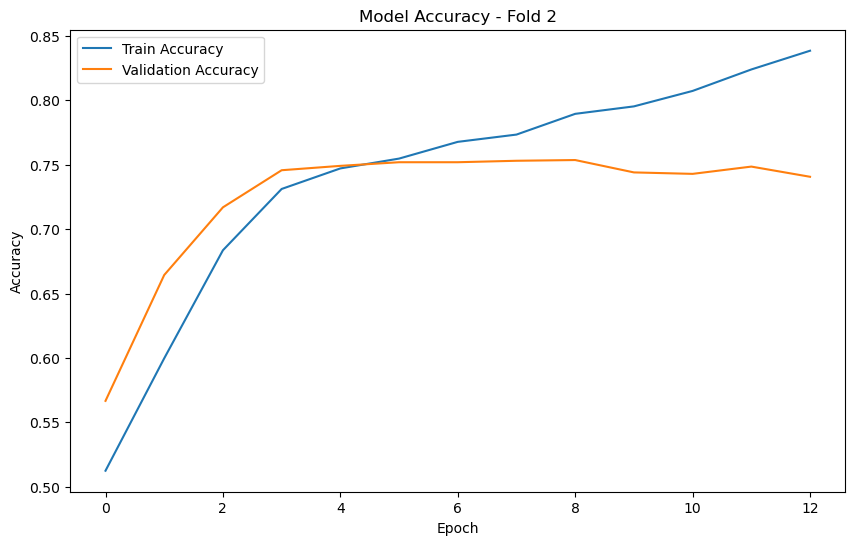

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Validation Results:
Accuracy: 0.7531
Balanced Accuracy: 0.7508
MCC: 0.5038
Sensitivity: 0.7906
Specificity: 0.7110
Confusion Matrix:
TN: 593, FP: 241
FN: 196, TP: 740

Confusion Matrix Format:
[[593 241]
 [196 740]]
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4955 - loss: 0.7082 - val_accuracy: 0.5209 - val_loss: 0.6909 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5583 - loss: 0.6821 - val_accuracy: 0.5712 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6069 - loss: 0.6585 - val_accuracy: 0.7085 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6989 - loss: 0.5744 - val_accuracy: 0.7271 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7263 - loss: 0.5477 - val_accuracy: 0.7277 - val_loss: 0.5467 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7425 - loss: 0.5246 - val_accuracy: 0.7362 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7620 - loss: 0.5071 - val_

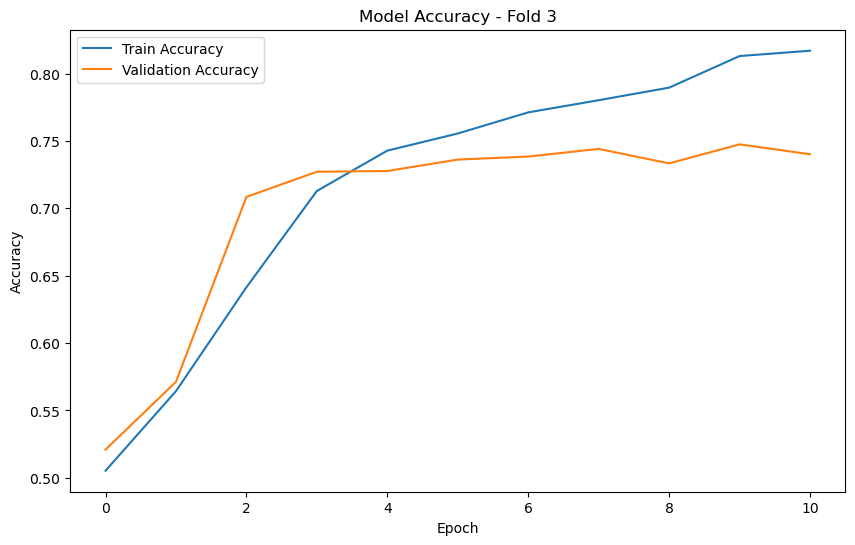

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Fold 3 Validation Results:
Accuracy: 0.7362
Balanced Accuracy: 0.7343
MCC: 0.4724
Sensitivity: 0.7919
Specificity: 0.6768
Confusion Matrix:
TN: 580, FP: 277
FN: 190, TP: 723

Confusion Matrix Format:
[[580 277]
 [190 723]]
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5023 - loss: 0.7142 - val_accuracy: 0.6000 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6027 - loss: 0.6673 - val_accuracy: 0.6571 - val_loss: 0.6240 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6716 - loss: 0.6142 - val_accuracy: 0.7017 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7201 - loss: 0.5683 - val_accuracy: 0.7096 - val_loss: 0.5666 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7319 - loss: 0.5362 - val_accuracy: 0.7175 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7462 - loss: 0.5137 - val_accuracy: 0.7328 - val_loss: 0.5401 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7665 - loss: 0.4963 - val_

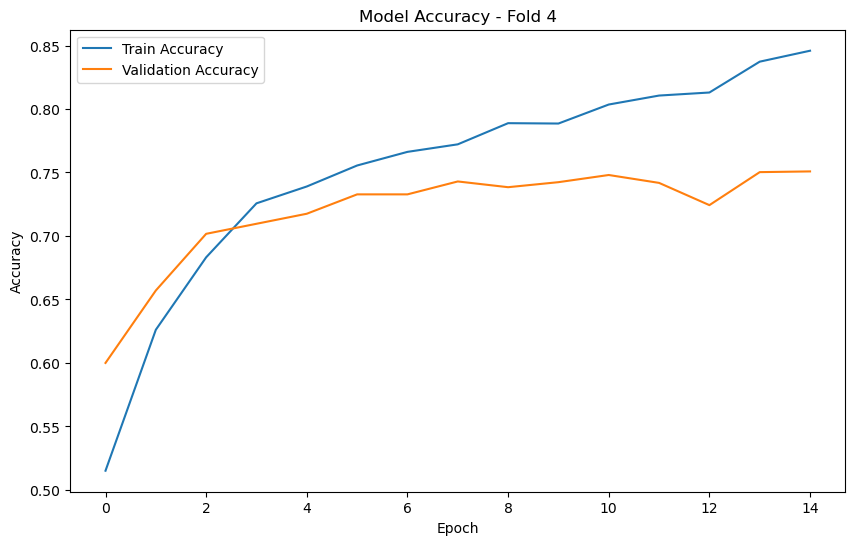

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Validation Results:
Accuracy: 0.7424
Balanced Accuracy: 0.7428
MCC: 0.4854
Sensitivity: 0.7295
Specificity: 0.7561
Confusion Matrix:
TN: 648, FP: 209
FN: 247, TP: 666

Confusion Matrix Format:
[[648 209]
 [247 666]]
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5120 - loss: 0.7120 - val_accuracy: 0.5198 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5321 - loss: 0.6900 - val_accuracy: 0.5644 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5800 - loss: 0.6768 - val_accuracy: 0.6390 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6399 - loss: 0.6350 - val_accuracy: 0.6757 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6803 - loss: 0.5959 - val_accuracy: 0.7051 - val_loss: 0.5707 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7157 - loss: 0.5601 - val_accuracy: 0.7062 - val_loss: 0.5603 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7285 - loss: 0.5396 - val_

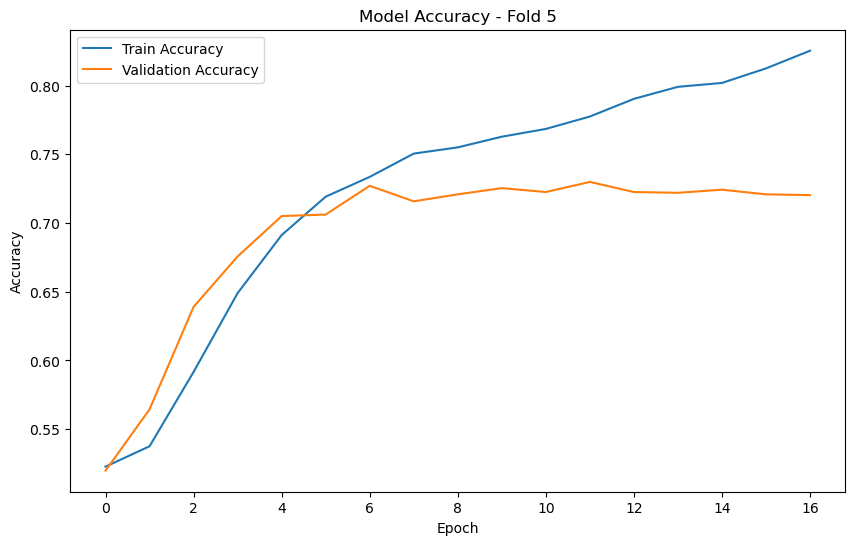

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Fold 5 Validation Results:
Accuracy: 0.7299
Balanced Accuracy: 0.7281
MCC: 0.4591
Sensitivity: 0.7786
Specificity: 0.6776
Confusion Matrix:
TN: 578, FP: 275
FN: 203, TP: 714

Confusion Matrix Format:
[[578 275]
 [203 714]]
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Cross-validation Complete

Average Cross-validation Results:
ACC: 0.7418 ± 0.0082
BALANCED_ACC: 0.7401 ± 0.0080
MCC: 0.4841 ± 0.0167
SN: 0.7866 ± 0.0360
SP: 0.6936 ± 0.0374

Final Test Set Evaluation

Test Set Results:
Accuracy: 0.7037
Balanced Accuracy: 0.7378
MCC: 0.2829
Sensitivity: 0.7792
Specificity: 0.6964
Confusion Matrix:
TN: 1739, FP: 758
FN: 53, TP: 187

Confusion Matrix Format:
[[1739  758]
 [  53  187]]


In [8]:
if __name__ == "__main__":
    model = train_and_evaluate()